#Importing Libraries

In [35]:
from PIL import Image                   #Library for converting and saving images 
import numpy as np                      #Library for most of algebraic operations 
import torch                            #Pytorch module to implement neural networks
import torch.nn as nn                   #Contains various functions like Linear, sequential as well as activation
import matplotlib.pyplot as plt         #Library used for plotting graphs
from torchvision import models
from torchsummary import summary

#Harmonic Osscilator
Here as this partial derivative equation has analytical solutions so we can create our own dataset in order to train our neural network and compare it with Physics Informed Neural Network

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$

In [36]:
"""
Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
"""
def oscillator(d, w0, x):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

#Neural Network 
Here we can input an array which has information regarding number of neurons in each layer and size of array represents the number of layers which include input, output and hidden layer

In [37]:
class PINN(nn.Module):
  def __init__(self, layer):
    super(PINN, self).__init__()
    activation = nn.Tanh
    self.input_layer = nn.Sequential(nn.Linear(layer[0],layer[1]), activation())
    self.hidden_layer = nn.Sequential(*[nn.Sequential(*[nn.Linear(layer[i], layer[i+1]),activation()]) for i in range(1,len(layer)-2)])
    self.output_layer = nn.Linear(layer[len(layer)-2],layer[len(layer)-1])

  def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

#Creating dataset

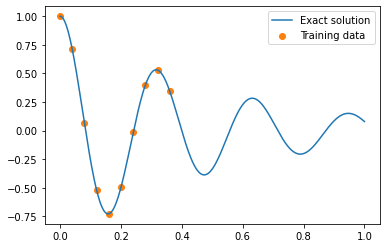

In [39]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
'''
The main reason we are doin this is that in real life 
'''
# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

#Helper function to plot graphs

In [44]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(epochs+1),fontsize="xx-large",color="k")
    plt.axis("off")

#Training the neural network without taking into account Physics Loss
Here I have made a neural network with two hidden layers each having 32 neurons and trained on very small input data for 10,000 epochs

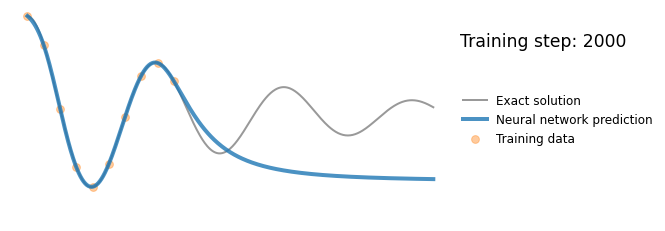

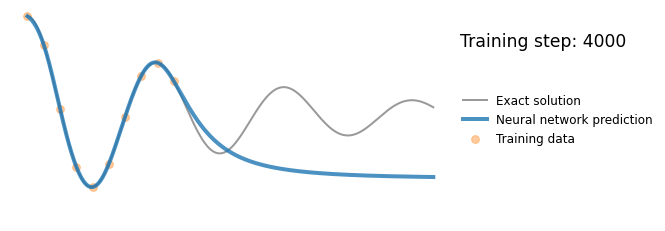

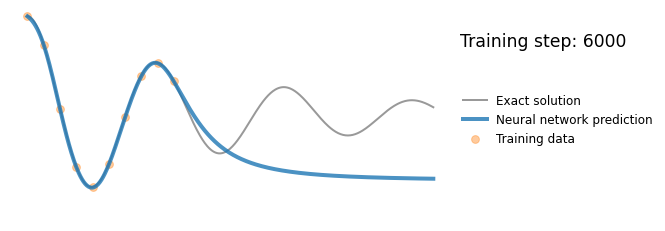

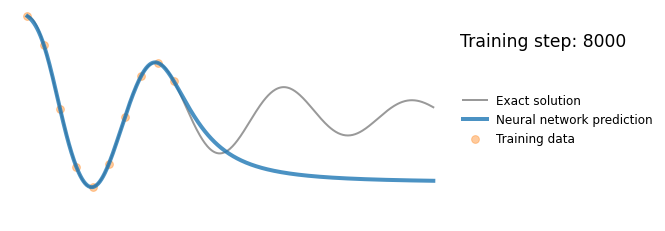

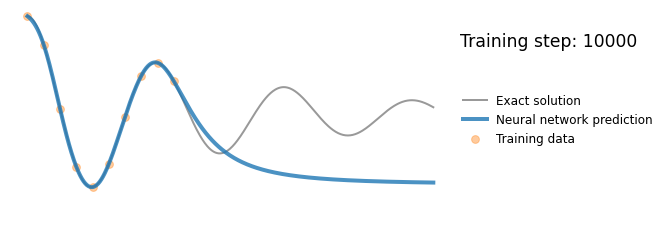

In [52]:
#Without implementing physics loss
layers = np.array([1,32,32,32,1])
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for epochs in range(10000):
  y_pred = model(x_data)
  loss = torch.mean((y_pred-y_data)**2)      # use mean squared error
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epochs+1)%2000 == 0:
    yh = model(x).detach()
    plot_result(x,y,x_data,y_data,yh)
    if (epochs+1) % 2000 == 0:
      plt.show()
    else: 
      plt.close("all")

#Training the neural network with Physics Loss
Here we can clearly see we were better able to map out the fucntion in same number of epochs

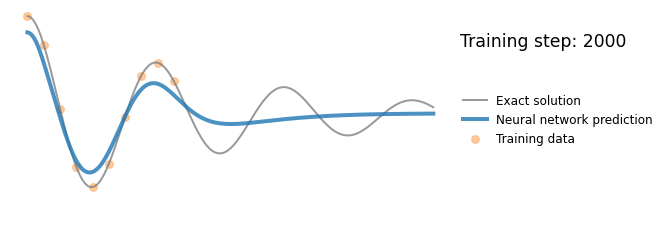

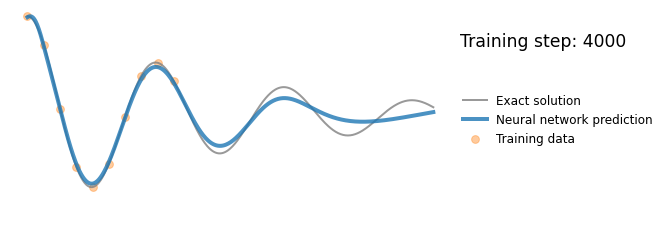

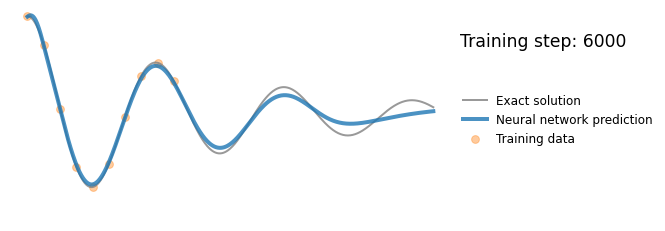

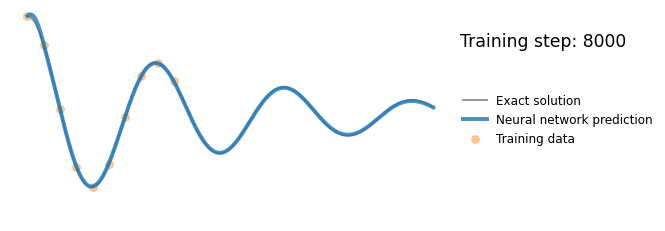

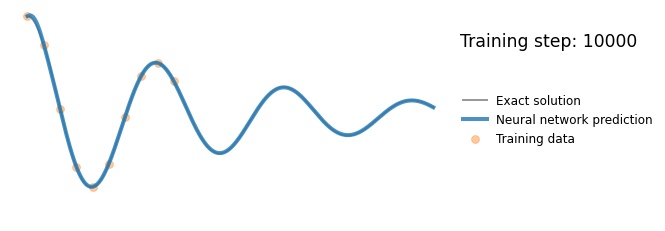

In [53]:
#With taking into consideration Physics loss
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
layers = np.array([1,32,32,32,1])
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for epochs in range(10000):
  y_pred = model(x_data)

  #data loss
  loss1 = torch.mean((y_pred-y_data)**2)      # use mean squared error

  #physics loss
  yhp = model(x_physics)
  dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
  dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
  physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
  loss2 = (1e-4)*torch.mean(physics**2)

  loss = loss1 + loss2
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epochs+1)%2000 == 0:
    yh = model(x).detach()
    plot_result(x,y,x_data,y_data,yh)
    if (epochs+1) % 2000 == 0:
      plt.show()
    else: 
      plt.close("all")